In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from matplotlib import image
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.2.0+cu118
Torchvision Version:  0.17.0+cu118
Using the GPU!


## Step 0: Downloading the dataset and backbone network.
A pretrained VGG 19 will be applied to extract features.

In [2]:
# Download the VGG19 model
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, start=0):
        out = {}
        if start == 0:
            out['conv11'] = self.conv1_1(x)
            out['r11'] = F.relu(out['conv11'])
            out['conv12'] = self.conv1_2(out['r11'])
            out['r12'] = F.relu(out['conv12'])
            out['p1'] = self.pool1(out['r12'])

            out['conv21'] = self.conv2_1(out['p1'])
            out['r21'] = F.relu(out['conv21'])

        if start == 1:
            out['r21'] = x
        if start <= 1:
            out['conv22'] = self.conv2_2(out['r21'])
            out['r22'] = F.relu(out['conv22'])
            out['p2'] = self.pool2(out['r22'])

            out['conv31'] = self.conv3_1(out['p2'])
            out['r31'] = F.relu(out['conv31'])

        if start == 2:
            out['r31'] = x
        if start <= 2:
            out['conv32'] = self.conv3_2(out['r31'])
            out['r32'] = F.relu(out['conv32'])
            out['conv33'] = self.conv3_3(out['r32'])
            out['r33'] = F.relu(out['conv33'])
            out['conv34'] = self.conv3_4(out['r33'])
            out['r34'] = F.relu(out['conv34'])
            out['p3'] = self.pool3(out['r34'])
        
            out['conv41'] = self.conv4_1(out['p3'])
            out['r41'] = F.relu(out['conv41'])
        
        if start == 3:
            out['r41'] = x
        if start <= 3:
            out['conv42'] = self.conv4_2(out['r41'])
            out['r42'] = F.relu(out['conv42'])
            out['conv43'] = self.conv4_3(out['r42'])
            out['r43'] = F.relu(out['conv43'])
            out['conv44'] = self.conv4_4(out['r43'])
            out['r44'] = F.relu(out['conv44'])
            out['p4'] = self.pool4(out['r44'])

            out['conv51'] = self.conv5_1(out['p4'])
            out['r51'] = F.relu(out['conv51'])

        if start == 4:
            out['r51'] = x
        if start <= 4:
            out['conv52'] = self.conv5_2(out['r51'])
            out['r52'] = F.relu(out['conv52'])
            out['conv53'] = self.conv5_3(out['r52'])
            out['r53'] = F.relu(out['conv53'])
            out['conv54'] = self.conv5_4(out['r53'])
            out['r54'] = F.relu(out['conv54'])
            out['p5'] = self.pool5(out['r54'])
        return out

cnn = VGG(pool='avg').eval().to('cuda')
cnn.load_state_dict(torch.load('./Models/vgg_conv.pth'))

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

## STEP 1: Create the image loader and some utility funtions
Provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

In [3]:
# Dataloader
imsize = (256, 256)

VGG19_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
VGG19_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=VGG19_MEAN.tolist(),
            std=VGG19_STD.tolist(),
        ),
        transforms.Lambda(lambda x: x.mul(255)),
        # It seems that the torchvision's VGG19 implementation is expecting the input to be in the 0-255 range, instead of 0-1
    ])
    image = transform(image)
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image.to(device, torch.float)

# visualizing the content and style images

A = image_loader("./Images/anni.jpg", imsize)
B_ = image_loader("./Images/mona.jpg", imsize)

print(A.shape)
print(B_.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


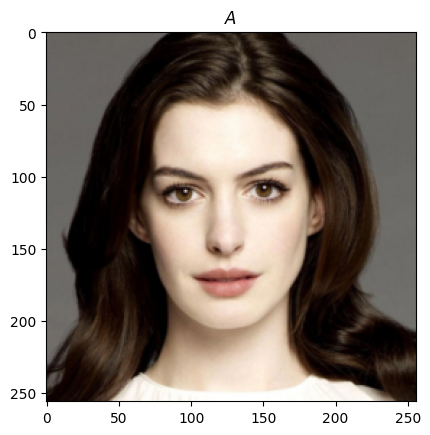

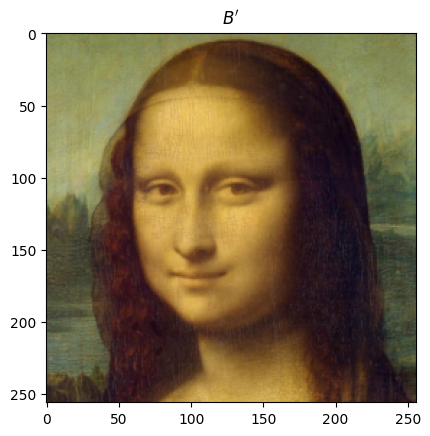

In [4]:
deprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.mul(1/255)),
    transforms.Normalize(
        (0, 0, 0),
        (1.0 / VGG19_STD).tolist(),
    ),
    transforms.Normalize(
        (-VGG19_MEAN).tolist(),
        (1, 1, 1),
    ),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.ToPILImage(),
])

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image[0])
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(A, title='$A$')

plt.figure()
imshow(B_, title="$B'$")

## Step 2: Preprocess

First, we need to get the feature maps.

In [5]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = cnn(x)
    return feats

We only need five layers.

In [6]:
layers = ['r11', 'r21', 'r31', 'r41', 'r51']
feats_A = {k: v for k, v in get_feature_maps(A, cnn).items() if k in layers}
feats_B_ = {k: v for k, v in get_feature_maps(B_, cnn).items() if k in layers}

Initialize $F_{A'}^5$ and $F_B^5$ with $F_A^5$ $F_{B'}^5$ respectively (i.e. assume they are the same in the deepest layer).

In [7]:
feats_A_ = dict()
feats_B = dict()

feats_A_['r51'] = feats_A['r51']
feats_B['r51'] = feats_B_['r51']

## Step 3: Nearest-neighbor Field Search

Identify a mapping function

$$
\phi^L_{a\rightarrow b}(p)=\arg \min\limits_q \sum\limits_{x\in N(p),y\in N(q)}(||\bar{F}_A^L(x)-\bar{F}_B^L(y)||^2+||\bar{F}_{A'}^L(x)-\bar{F}_{B}'^L(y)||^2),
$$
where $N(p)$ is a patch around $p$, and $\bar{F}^L(x)=\frac{{F}^L(x)}{|{F}^L(x)|}$.

One idea is that $\phi^L_{a\rightarrow b}$ is constrained by $\phi^{L+1}_{b\rightarrow a}$ through $F_B^L$.

First, assume we have known the feature maps of one specific layer, we need to implement the function to find out the mapping relationship.

In [8]:
def normalize(feat):
    return feat / torch.norm(feat)

F_A5 = normalize(feats_A['r51'])
F_B5 = normalize(feats_B['r51'])
F_A_5 = normalize(feats_A_['r51'])
F_B_5 = normalize(feats_B_['r51'])

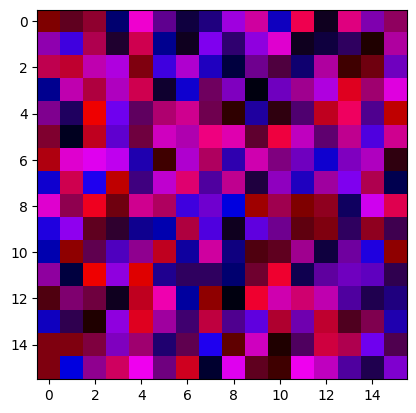

In [9]:
from Patch_Match import PatchMatch  # Patch_Match.py should be in the same directory as this notebook


pm = PatchMatch(F_A5, F_B5, F_A_5, F_B_5, patch_size=3)
# pm = PatchMatch(A, B_, A, B_, patch_size=3)
nnf = pm.visualize()
plt.imshow(nnf)

In [10]:
pm.propagate(iters=5, search_radius=4)

Propagation iteration 1 done
Propagation iteration 2 done
Propagation iteration 3 done
Propagation iteration 4 done
Propagation iteration 5 done


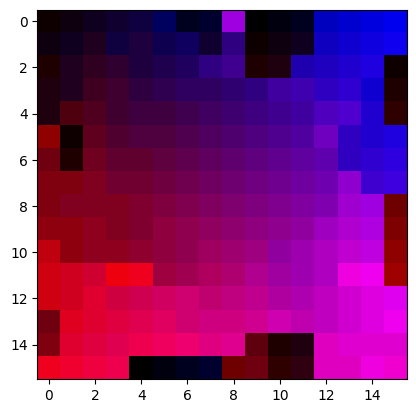

In [11]:
nnf = pm.visualize()
plt.imshow(nnf)

In [12]:
img_A = deprocess(A[0])
img_B = deprocess(B_[0])
numpy_A = np.array(img_A)
numpy_B = np.array(img_B)
recon_A = pm.reconstruct(numpy_A, numpy_B)

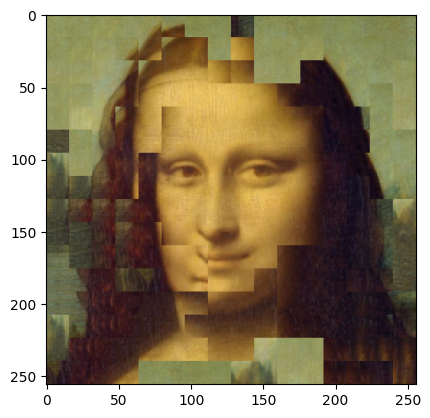

In [13]:
plt.figure()
plt.imshow(recon_A)

In [14]:
pm.nnf  # This is the matching map we are interested in

array([[[ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 0,  6],
        [ 0,  2],
        [ 0,  3],
        [10, 14],
        [ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15]],

       [[ 1,  1],
        [ 1,  2],
        [ 2,  2],
        [ 1,  4],
        [ 2,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  3],
        [ 3,  8],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 1, 12],
        [ 1, 13],
        [ 1, 14],
        [ 1, 15]],

       [[ 2,  0],
        [ 2,  2],
        [ 3,  2],
        [ 3,  3],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 3,  8],
        [ 4,  9],
        [ 2,  0],
        [ 2,  1],
        [ 2, 11],
        [ 2, 12],
        [ 2, 13],
        [ 2, 14],
        [ 1,  0]],

       [[ 2,  1],
        [ 2,  2],
        [ 4,  2],
        [ 4,  3],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
    

## Step 4: Latent Image Reconstruction

The next step is to get $F_{A'}^4$ and $F_{B}^4$ and feature maps of even lower layers.

First, we need to warp $F_{B'}^5$.

In [15]:
def warp_feature_map(feat, matches):
    """
    warp the feature map using the matches.
    
    Inputs:
    - feat: A tensor of shape (B, C, H, W)
    - matches: A numpy array of shape (H, W, 2)
    
    Returns:
    - warped: A tensor of shape (B, C, H, W)
    """
    H, W, _ = matches.shape
    warped = torch.zeros_like(feat)
    for i in range(H):
        for j in range(W):
            a, b = matches[i, j]
            warped[:, :, a, b] = feat[:, :, i, j]
    return warped

In [16]:
pm5_b2a = PatchMatch(
    feats_A['r51'], feats_B['r51'], feats_A_['r51'], feats_B_['r51'], 
    patch_size=3
    )
pm5_a2b = PatchMatch(
    feats_B['r51'], feats_A['r51'], feats_B_['r51'], feats_A_['r51'], 
    patch_size=3
    )

patch_radii = [500,6,6,4,4]
pm5_b2a.propagate(iters=5, search_radius=patch_radii[4])
pm5_a2b.propagate(iters=5, search_radius=patch_radii[4])

Propagation iteration 1 done
Propagation iteration 2 done
Propagation iteration 3 done
Propagation iteration 4 done
Propagation iteration 5 done
Propagation iteration 1 done
Propagation iteration 2 done
Propagation iteration 3 done
Propagation iteration 4 done
Propagation iteration 5 done


In [17]:
matches5_b2a = pm5_b2a.nnf
matches5_a2b = pm5_a2b.nnf
F5_b2a = warp_feature_map(feats_B_['r51'], matches5_b2a)
F5_a2b = warp_feature_map(feats_A['r51'], matches5_a2b)

Use optimization to get $R_{B'}^4$.

In [18]:
def deconv(r, f, cnn, start, end, iter=100, showevery=10):
    """
    Inputs:
    - r: The feature map to be optimized
    - f: The feature map to match
    - cnn: The VGG model
    - start: The layer to start from, e.g. 3
    - end: The layer to end at, e.g. 'r51'

    Returns:
    - r: The optimized feature map
    """
    optimizer = optim.LBFGS([r])
    for i in range(iter):
        def closure():
            optimizer.zero_grad()
            cnn_r = cnn(r, start=start)[end]
            loss = F.mse_loss(cnn_r, f, reduction='sum')
            loss.backward()
            return loss
        optimizer.step(closure)
        if (i+1) % showevery == 0:
            print(f"Iteration {i+1}: Loss {closure().item()}")
    return r.detach()


r4_B_ = torch.randn_like(feats_B_['r41'], requires_grad=True)
r4_A = torch.randn_like(feats_A['r41'], requires_grad=True)
r4_B_ = deconv(r4_B_, F5_b2a, cnn, start=3, end='r51', iter=0)
r4_A = deconv(r4_A, F5_a2b, cnn, start=3, end='r51', iter=0)
print(r4_B_.shape, r4_A.shape)

torch.Size([1, 512, 32, 32]) torch.Size([1, 512, 32, 32])


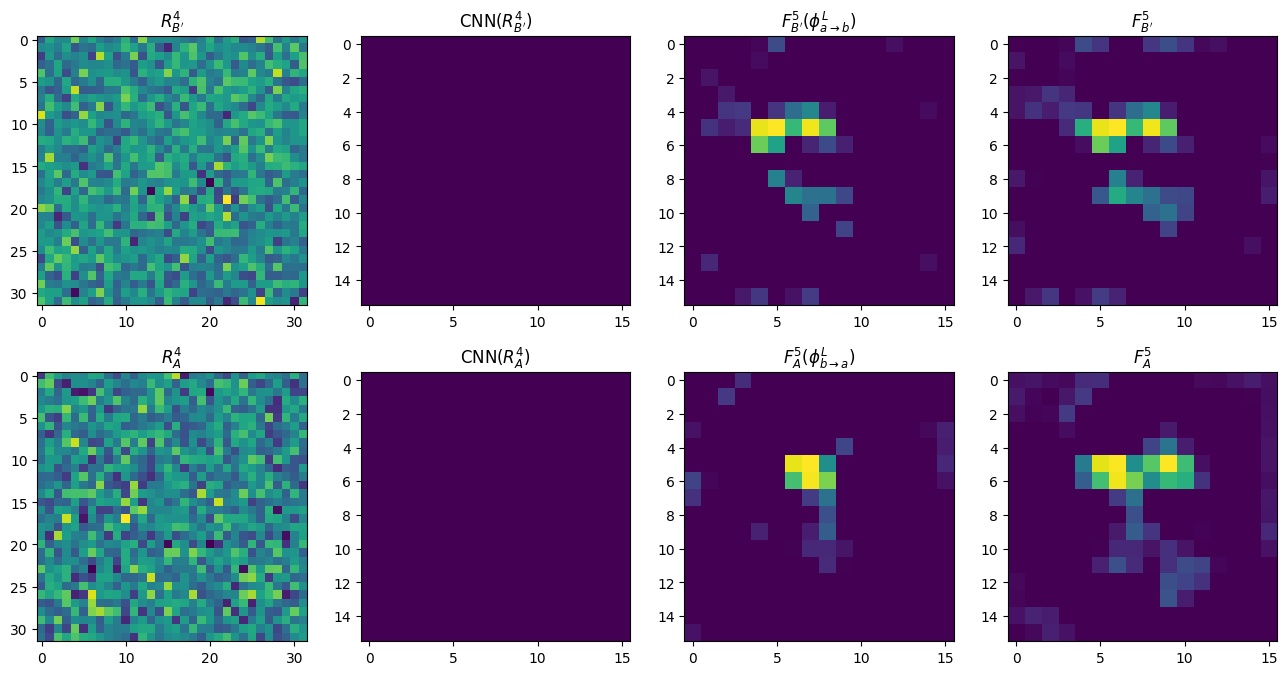

In [19]:
# visualize the deconvolved feature maps
plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.imshow(r4_B_[0, 0].cpu().numpy())
plt.title("$R^{4}_{B'}$")
plt.subplot(242)
plt.imshow(cnn(r4_B_, start=3)['r51'][0, 0].cpu().detach().numpy())
plt.title("$\\text{CNN}(R^{4}_{B'})$")
plt.subplot(243)
plt.imshow(F5_b2a[0, 0].cpu().numpy())
plt.title("$F^{5}_{B'}(\phi^L_{a \\rightarrow b})$")
plt.subplot(244)
plt.imshow(feats_B_['r51'][0, 0].cpu().numpy())
plt.title("$F^{5}_{B'}$")
plt.subplot(245)
plt.imshow(r4_A[0, 0].cpu().numpy())
plt.title("$R^{4}_{A}$")
plt.subplot(246)
plt.imshow(cnn(r4_A, start=3)['r51'][0, 0].cpu().detach().numpy())
plt.title("$\\text{CNN}(R^{4}_{A})$")
plt.subplot(247)
plt.imshow(F5_a2b[0, 0].cpu().numpy())
plt.title("$F^{5}_{A}(\phi^L_{b \\rightarrow a})$")
plt.subplot(248)
plt.imshow(feats_A['r51'][0, 0].cpu().numpy())
plt.title("$F^{5}_{A}$")
plt.show()


In [20]:
def blend_feature(feat, r, alpha):
    feat_norm = (feat - feat.min()) / (feat.max() - feat.min())
    weight = alpha * 1 / (1 + torch.exp(-300 * feat_norm**2 - 0.05))
    return weight * feat + (1 - weight) * r


alphas = [0.8, 0.7, 0.6, 0.1]
feats_A_['r41'] = blend_feature(feats_A['r41'], r4_A, alphas[3])
feats_B['r41'] = blend_feature(feats_B_['r41'], r4_B_, alphas[3])

Then for Layer 4 iteratively.

In [21]:
patch_sizes = {'r11': 5, 'r21': 5, 'r31': 3, 'r41': 3, 'r51': 3}
pm4_b2a = PatchMatch(
    feats_A['r41'], feats_B['r41'], feats_A_['r41'], feats_B_['r41'], 
    patch_size=patch_sizes['r41']
    )
pm4_a2b = PatchMatch(
    feats_B['r41'], feats_A['r41'], feats_B_['r41'], feats_A_['r41'], 
    patch_size=patch_sizes['r41']
    )
pm4_b2a.nff = pm4_b2a.upsample(size=feats_A['r41'].shape[-2])
pm4_a2b.nff = pm4_a2b.upsample(size=feats_B['r41'].shape[-2])
# pm4_b2a.propagate(iters=5, search_radius=patch_radii[3])
# pm4_a2b.propagate(iters=5, search_radius=patch_radii[3])

In [22]:
recon_A = pm4_a2b.reconstruct(numpy_A, numpy_B)
recon_B = pm4_b2a.reconstruct(numpy_B, numpy_A)

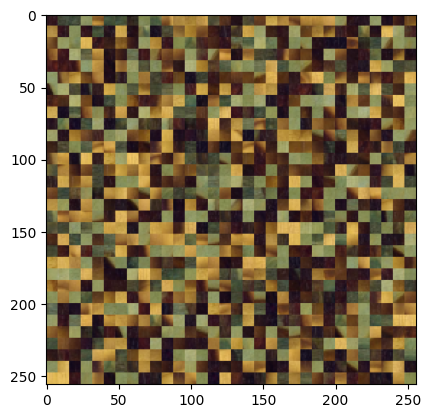

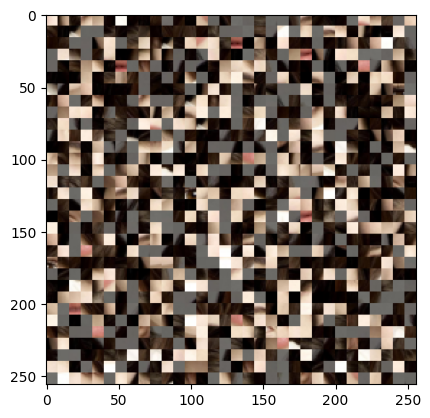

In [23]:
plt.figure()
plt.imshow(recon_A)
plt.figure()
plt.imshow(recon_B)